In [ ]:

import os, glob, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import roc_curve, auc, accuracy_score


In [ ]:

# Automatically use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Parameters
ROOT_DIR = r"C:\Users\gupta\OneDrive\Desktop\misba_model\signatures"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


Using device: cuda


In [ ]:

def scan_dataset(root_dir):
    writers = {}
    for writer_folder in sorted(os.listdir(root_dir)):
        wpath = os.path.join(root_dir, writer_folder)
        if not os.path.isdir(wpath): continue
        genuine = glob.glob(os.path.join(wpath, "original*.png"))
        forged = glob.glob(os.path.join(wpath, "forgeries*.png"))
        writers[writer_folder] = {"genuine": genuine, "forged": forged}
    return writers

writers_dict = scan_dataset(ROOT_DIR)
print("Total writers:", len(writers_dict))


Total writers: 55


In [ ]:

class SignaturePairDataset(Dataset):
    def __init__(self, writers_dict, transform=None, num_pairs_per_writer=20):
        self.pairs = []
        self.transform = transform

        for w, files in writers_dict.items():
            genuine = files["genuine"]
            forged = files["forged"]

            # Positive pairs (genuine-genuine)
            for _ in range(num_pairs_per_writer):
                if len(genuine) >= 2:
                    a, b = random.sample(genuine, 2)
                    self.pairs.append((a, b, 1))

            # Negative pairs (genuine-forged)
            for _ in range(num_pairs_per_writer):
                if len(genuine) >= 1 and len(forged) >= 1:
                    a = random.choice(genuine)
                    b = random.choice(forged)
                    self.pairs.append((a, b, 0))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path1, path2, label = self.pairs[idx]
        img1 = Image.open(path1).convert("L")
        img2 = Image.open(path2).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])


In [ ]:

all_writers = list(writers_dict.keys())
random.shuffle(all_writers)

split = int(0.8 * len(all_writers))
train_writers = {w: writers_dict[w] for w in all_writers[:split]}
test_writers  = {w: writers_dict[w] for w in all_writers[split:]}

train_ds = SignaturePairDataset(train_writers, transform=transform)
test_ds  = SignaturePairDataset(test_writers, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Train pairs:", len(train_ds), "Test pairs:", len(test_ds))


Train pairs: 1760 Test pairs: 440


In [ ]:

class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        base.fc = nn.Linear(base.fc.in_features, 128)  # embedding size 128
        self.base = base

    def forward_once(self, x):
        return self.base(x.repeat(1,3,1,1))  # convert gray->3 channels

    def forward(self, x1, x2):
        e1 = self.forward_once(x1)
        e2 = self.forward_once(x2)
        return e1, e2

def contrastive_loss(e1, e2, label, margin=1.0):
    dist = F.pairwise_distance(e1, e2)
    loss = torch.mean(label * dist**2 + (1-label) * F.relu(margin - dist)**2)
    return loss, dist


In [ ]:

model = SiameseNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(DEVICE), img2.to(DEVICE), label.to(DEVICE)

        e1, e2 = model(img1, img2)
        loss, _ = contrastive_loss(e1, e2, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}")


C:\Users\gupta\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gupta\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\gupta/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:12<00:00, 3.79MB/s]


Epoch 1/10, Loss: 1.3201
Epoch 2/10, Loss: 0.1517
Epoch 3/10, Loss: 0.1043
Epoch 4/10, Loss: 0.0724
Epoch 5/10, Loss: 0.0508
Epoch 6/10, Loss: 0.0385
Epoch 7/10, Loss: 0.0324
Epoch 8/10, Loss: 0.0229
Epoch 9/10, Loss: 0.0187
Epoch 10/10, Loss: 0.0175


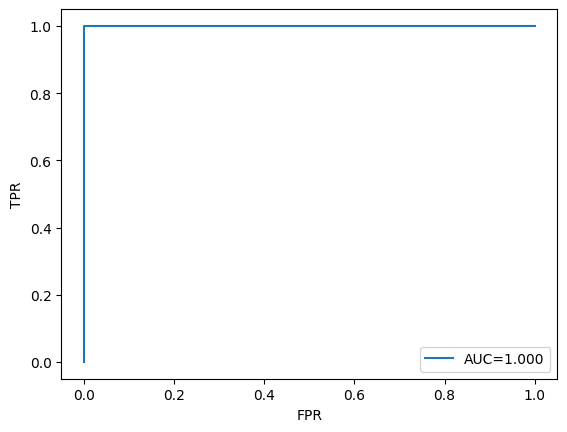

In [ ]:

model.eval()
labels, scores = [], []

with torch.no_grad():
    for img1, img2, label in test_loader:
        img1, img2 = img1.to(DEVICE), img2.to(DEVICE)
        e1, e2 = model(img1, img2)
        dist = F.pairwise_distance(e1, e2).cpu().numpy()
        scores.extend(dist)
        labels.extend(label.numpy())

fpr, tpr, thr = roc_curve(labels, -np.array(scores))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.show()


In [ ]:

threshold = np.median(scores)
preds = [1 if s < threshold else 0 for s in scores]
acc = accuracy_score(labels, preds)
print("Test Accuracy:", acc)


Test Accuracy: 1.0


In [ ]:

# --- Save the trained model ---
MODEL_PATH = r"C:\Users\gupta\OneDrive\Desktop\misba_model\siamese_signature.pth"
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved at:", MODEL_PATH)

# --- Function to load model ---
def load_siamese(model_path):
    model = SiameseNet().to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    return model

# --- Function to compare two signature images ---
def verify_signature(model, img_path1, img_path2, transform, threshold=None):
    img1 = Image.open(img_path1).convert("L")
    img2 = Image.open(img_path2).convert("L")

    img1 = transform(img1).unsqueeze(0).to(DEVICE)
    img2 = transform(img2).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        e1, e2 = model(img1, img2)
        dist = F.pairwise_distance(e1, e2).item()

    if threshold is None:
        threshold = 0.5  # default, you can adjust based on ROC/validation

    result = "Genuine" if dist < threshold else "Forgery"
    return result, dist

# --- Example usage ---
model = load_siamese(MODEL_PATH)
img1 = r"C:\Users\gupta\OneDrive\Desktop\misba_model\signatures\signatures_1\original_1_1.png"
img2 = r"C:\Users\gupta\OneDrive\Desktop\misba_model\signatures\signatures_1\forgeries_1_1.png"

result, distance = verify_signature(model, img1, img2, transform, threshold=np.median(scores))
print("Result:", result, "Distance:", distance)


Model saved at: C:\Users\gupta\OneDrive\Desktop\misba_model\siamese_signature.pth


C:\Users\gupta\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gupta\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\gupta\AppData\Local\Temp\ipykernel_5672\2650392372.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/

Result: Forgery Distance: 3.257835865020752
